__Author(s): Chaojie Feng__<br/>
__Github: https://github.com/fcjscott__<br/>
__Collaborator(s): Individual__<br/>
__External Resources: Resourced from Atsushi Sakai's Python Robotics Demo__<br/>
__Specific Contributions: ALL__<br/>
__Aggregate Contributions: 100%__<br/>

In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# fixed parameters
l = 80
w = 85
c = 10
r = 20
R = 115

# 1 Robot Model

You will again consider the 2 wheeled robot from lab 3, this time ignoring sensors and noise terms. For simplicity, you can consider the robot to be a circle of diameter 115mm. For realism, you can optionally consider the true shape of the robot to be a rectangle of length $l = 80mm$ and width $w = 85mm$; the center of the axle is $c = 10mm$ from the front of the robot. In addition, the wheel radius is $r_w = 20 mm$

The dynamics of robot can be representad as following:

$$\begin{bmatrix}\dot{x}\\ \dot{y}\\\dot{\theta} \end{bmatrix} =  \left[\begin{array}{cc} cos\theta & 0 \\
sin\theta & 0 \\ 0 & 1\end{array}\right] \begin{bmatrix} \frac{\omega_L + \omega_R}{2}r \\ \frac{-\omega_L + \omega_R}{w}r \end{bmatrix}$$

Where $\omega_L$ and $\omega_R$ represent the left and right wheel speed respectively

# 2 Trajectory Planning

The robot must move through a cluttered 2D rectangular environment representing a parking lot. You will want to
consider geometric obstacles defined by rectangles specified within the space. For additional complexity, you may
want to include ”one-way” regions in the space that only permit motion in one direction (with motion in the other
directions represented by obstacles in C-space).
The robot must achieve a prescribed goal, i.e. a desired $x, y, θ$ for the robot state. Note that this robot is
non-holonomic: you only have two input controls for the 3-DOF state.
Compute a plan to take the robot from a given initial state to the desired goal state while avoiding obstacles,
and use that to implement a planner / controller specifying the inputs to the actuators as a function of time.

## 2.1 Find the nearest node

In [2]:
class node:
    """
    Build a class of node
    """
    def __init__(self,state):
        self.state = state
        self.parent = None

def NearestNode(V, target):
    """
    Based on a set of nodes in node list {V} and a target state, find the nearest
    node in V to the target state, and return the index of that node
    
    Input: 
    V = list(class(node1), class(node2), ...)
    target = np.array([x, y, theta])
    
    Output:
    nearest_node = np.array([x, y, theta])
    min_id = index
    """
    nearest_node = np.zeros(3)
    dmin = 10**10
    min_id = None
    for i,node in enumerate(V):
        d = np.linalg.norm(target - node.state)
        if d < dmin:
            dmin = d
            nearest_node = node
            min_id = i
    
    return nearest_node, min_id 
        


Given a set of points V in C-space and a single other target point, the nearest point to the target point can be found by `NearestNode()`. It iterates through all posible nodes in V and return the closest node in the data type of numpy array. The simulation is in the following section. Red dot represents target point and yellow dot represents nearest point

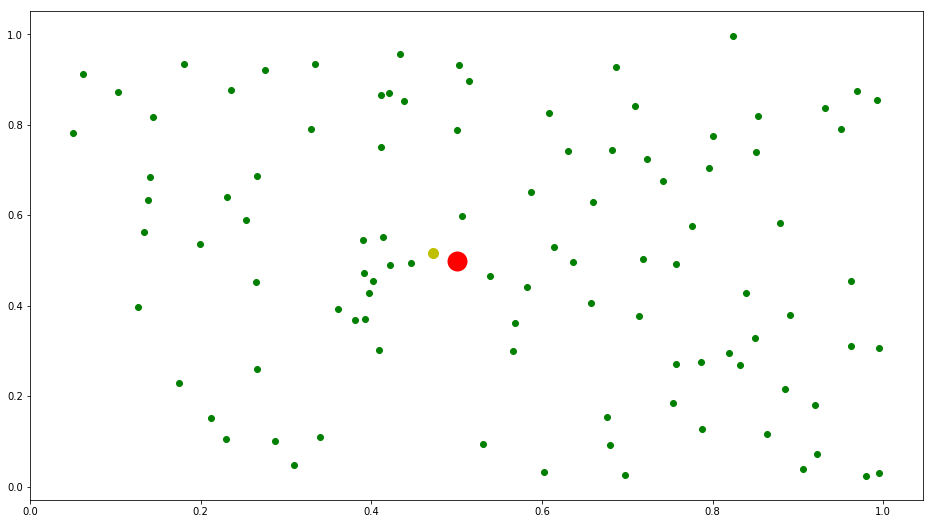

In [3]:
# Visualization of Nearest Node in 2D situation
V = []
plt.figure(figsize=(16,9))
for i in range(100):
    n = node(np.array([np.random.uniform(), np.random.uniform(), 0.5]))
    V.append(n)
    plt.scatter(V[i].state[0], V[i].state[1], c='g')

target = np.array([0.5,0.5,0.5])
plt.scatter(target[0],target[1], c='r',s = 100, linewidth = 10)
nearest_node, min_id = NearestNode(V, target)
plt.scatter(nearest_node.state[0],nearest_node.state[1], c='y', s = 100)
    

## 2.2 Generate smooth trajectories

In [4]:
def traj_generate(current_state, target_state, kr=0.3, ka=1.5, kb=-0.6, dt = 0.10, mode = 0):
    """
    Generate smooth trajectories given input state and goal state
    
    Input: 
    current_state = current position and orientation formed in numpy array [x,y,theta]
    target_state = target position and orientation formed in numpy array [x,y,theta]
    
    Output:
    trajectory = list of states along trajectory, with dt time interval
    u = list of control input
    """
    
    # extract states
    xi,yi,ti = current_state[0],current_state[1],current_state[2]
    xg,yg,tg = target_state[0],target_state[1],target_state[2]
    
    
    dx = xg - xi
    dy = yg -yi
    rho = np.sqrt(dx**2 + dy**2)
    
    #initialize trajectories
    trajectory = []
    u = []
    x,y,theta = xi,yi,ti
    
    t = 0.0
    
    while t <= 1.0 and rho >= 0.001:
        trajectory.append(np.array([x,y,theta]))
        dx = xg - x
        dy = yg -y
        
        rho = np.sqrt(dx**2 + dy**2)
        alpha = (np.arctan2(dy,dx) - theta + np.pi) %(2*np.pi) - np.pi
        beta = (tg - theta - alpha + np.pi) % (2*np.pi) - np.pi
        
        v = kr*rho
        omega = ka*alpha + kb*beta
        
        # investigate backward to control input
        omega_left = (2*v - omega*w)/(2*r)
        omega_right = (2*v + omega*w)/(2*r)
        u.append(np.array([omega_left,omega_right]))
        
        if alpha > np.pi/2 or alpha < -np.pi/2:
            v = -v
            
        theta = (theta + omega*dt) % (2 * np.pi)
        x = x + v*np.cos(theta)*dt
        y = y + v*np.sin(theta)*dt
        
        t += mode*dt
        #print(t)
        

        
    return trajectory, u
        
    
    

The trajectories of robot is defined by parametric equations. The control input of this trajectory will be $\omega_L$ and $\omega_R$ from wheels. Note that the trajectory might look not smooth in operation, especially looking from 2D perspective, it is actually continuous and smooth if $\theta$ is taken into consideration.

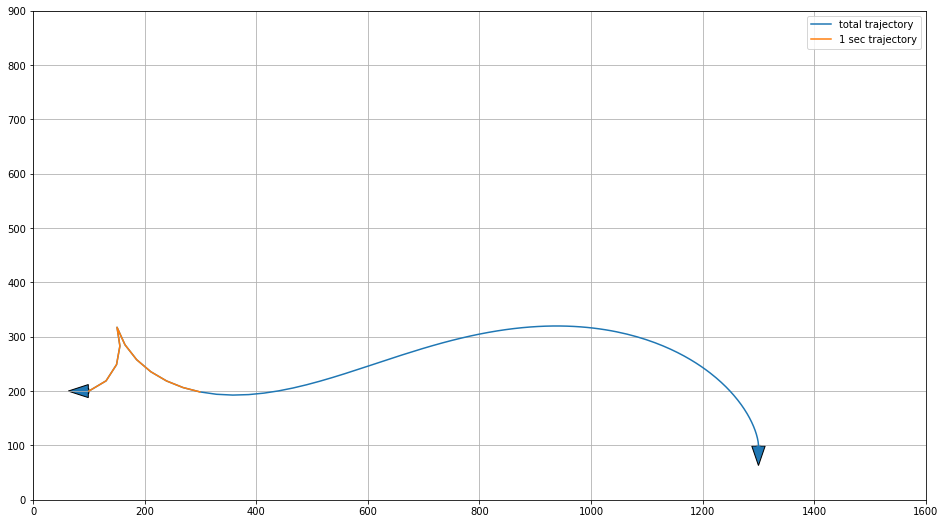

In [5]:
# simulated trajectoriies
xi = np.array([100,200,np.pi])
xf = np.array([1300,100,-np.pi/2])

traj_1s,_ = traj_generate(xi,xf,mode=0)
traj_total,_ = traj_generate(xi,xf,mode=1)
traj_1s = np.reshape(traj_1s, [len(traj_1s), 3])
traj_total = np.reshape(traj_total, [len(traj_total), 3])
plt.figure(figsize = (16,9))
plt.xlim((0,1600))
plt.ylim((0,900))
plt.plot(traj_1s[:,0],traj_1s[:,1])
plt.plot(traj_total[:,0],traj_total[:,1])
plt.arrow(xi[0],xi[1],np.cos(xi[2]),np.sin(xi[2]),width = 8)
plt.arrow(xf[0],xf[1],np.cos(xf[2]),np.sin(xf[2]),width = 8)
plt.legend(['total trajectory','1 sec trajectory'])
plt.grid(True)



## 2.3 Map Visualization in operation space and configuration space

In [6]:
def OperationSpace(current_state, target_state, obList, config = False):
    
    """
    Generate plot for operation space based on obstacle definition
    
    Input:
    current_state = numpy array([x,y,theta]) where specify robot's instantaneous state
    target_state = numpy array([x,y,theta]) where specify robot's goal
    obList = a list of rectangular obstacles formed as [O1,O2,....] where O is a 4-element 
    tuple to define rectangle
    config = a switch to specify wheter the robot is considered as a point in C-Space or the 
    robot is considered as a rigid body in O-Space
    """ 
    fig = plt.figure(figsize = (16,9))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim((0,1600))
    plt.ylim((0,900))
    plt.grid(True)
    plt.arrow(current_state[0], current_state[1], 
              np.cos(current_state[2]), np.sin(current_state[2]), width = 10, color = 'r')
    plt.arrow(target_state[0], target_state[1], 
              np.cos(target_state[2]), np.sin(target_state[2]), width = 10, color = 'g')
    
    if not config:
        current_circle = plt.Circle((current_state[0], current_state[1]),R/2,color = 'r',fill = 0)
        target_circle = plt.Circle((target_state[0], target_state[1]),R/2, color = 'g', fill = 0)
        ax.add_patch(current_circle)
        ax.add_patch(target_circle)
    for x in obList:
        ob = plt.Rectangle(x[0:2], x[2], x[3])
        ax.add_patch(ob)
            
        
    return ax
        
    

In order to simplify for the analysis of configuration space, the robot is modeled as a circular robot with diameter of 115 mm. The following figure shows the a virtual parking test environment. A test vehicle will need to perform head-in parking, rear-in parking as well as parallel parking in this environment

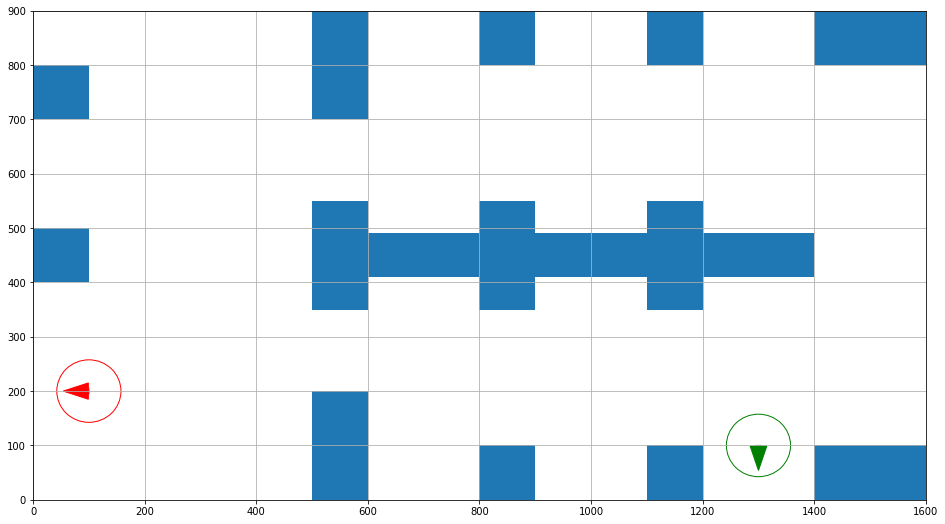

In [7]:
parkingLot = [(500, 350, 100, 200),
         (500, 0, 100, 200),
         (500,700,100,200),
         (600,410,800,80),
         (800,0,100,100),
         (1100,0,100,100),
         (1400,0,200,100),
         (800,800,100,100),
         (1100,800,100,100),
         (1400,800,200,100),
         (800,350,100,200),
         (1100,350,100,200),
         (0,700,100,100),
         (0,400,100,100)]



ax = OperationSpace(xi, xf, parkingLot)

In [8]:
def ConfigSpace(current_state,target_state,obList,chull = False):
    """
    Generate plot for configuration space
    
    Input:
    current_state = numpy array([x,y,theta]) where specify robot's instantaneous state
    target_state = numpy array([x,y,theta]) where specify robot's goal
    obList = a list of rectangular obstacles formed as [O1,O2,....] where O is a 4-element 
    tuple to define rectangle
    chull = a switch to tune the convex hull points in the graph
    """
    
    cvxpt = []
    offset = (np.sqrt(2)-1)*R/(2*np.sqrt(2))
    
    # draw operation space first
    ax = OperationSpace(current_state,target_state,obList,config = True)
    p = []
    for x in obList:
        
        # padding around obstacle to make configuration space
        r1 = plt.Rectangle((x[0]-R/2,x[1]),R/2,x[3])
        r2 = plt.Rectangle((x[0]+x[2],x[1]),R/2,x[3])
        r3 = plt.Rectangle((x[0],x[1]+x[3]),x[2],R/2)
        r4 = plt.Rectangle((x[0],x[1]-R/2),x[2],R/2)
        c1 = plt.Circle((x[0],x[1]),R/2)
        c2 = plt.Circle((x[0]+x[2],x[1]),R/2)
        c3 = plt.Circle((x[0]+x[2],x[1]+x[3]),R/2)
        c4 = plt.Circle((x[0],x[1]+x[3]),R/2)
        ax.add_patch(r1)
        ax.add_patch(r2)
        ax.add_patch(r3)
        ax.add_patch(r4)
        ax.add_patch(c1)
        ax.add_patch(c2)
        ax.add_patch(c3)
        ax.add_patch(c4)
        
        # return a set of convex hull points if chull is tuned on
        if chull:
            p1 = [x[0]-R/2,x[1]]
            p2 = [x[0]+x[2]+R/2,x[1]]
            p3 = [x[0]-R/2,x[1]+x[3]]
            p4 = [x[0]+x[2]+R/2,x[1]+x[3]]
            p5 = [x[0],x[1]-R/2]
            p6 = [x[0]+x[2],x[1]-R/2]
            p7 = [x[0],x[1]+x[3]+R/2]
            p8 = [x[0]+x[2],x[1]+x[3]+R/2]
            p9 = [x[0]-R/2+offset,x[1]-R/2+offset]
            p10 = [x[0]-R/2+offset,x[1]+x[3]+R/2-offset]
            p11 = [x[0]+x[2]+R/2-offset,x[1]-R/2+offset]
            p12 = [x[0]+x[2]+R/2-offset,x[1]+x[3]+R/2-offset]
            p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
            cvxpt.append(p)

            for point in p:
                pts = plt.scatter(point[0],point[1],c='k')
        
    return ax,cvxpt

Since the bot is modeled as circular shape, different rotation angle will not be in consideration because every rotation angle $\theta$ will yield to the same configuration space. As a result, the C-space figure is plotted in 2D version as following

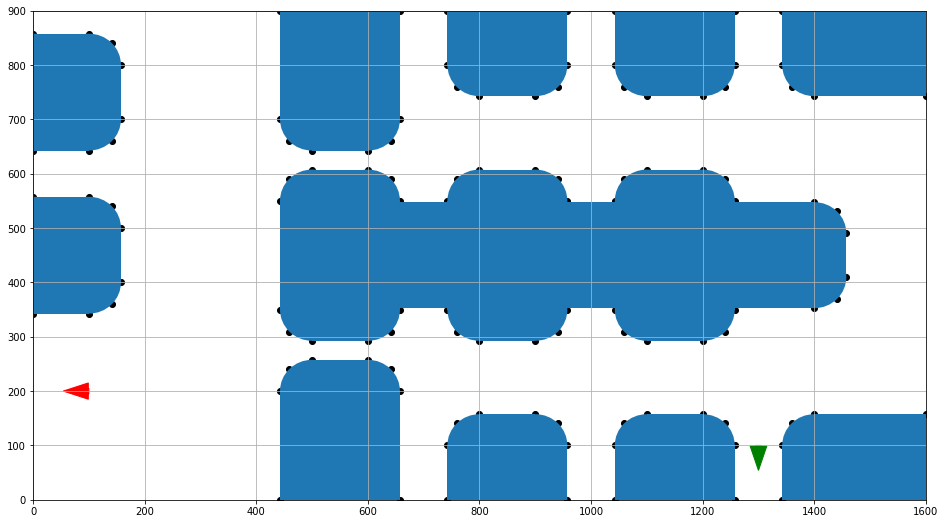

In [9]:
ax,cvxpt = ConfigSpace(xi,xf,parkingLot,chull = True)

## 2.4 Collision Free Checking

In [10]:
def collisionCheck(trajectory,cvxpt):
    """
    Determine wheter the obstacles will interfere with the robot trajectory or not
    
    Inputs:
    trajectory = a list of 3-element tuple describing the robot state along its movement
    cvxpt = a set of convex points on the boundary of obstacle which defines the convex hull
    formed as a list of list i.e. [[obstacle1],[obstacle2]......]
    
    Output:
    isCollision: a boolean determine whether collision will happen
    """
    # defalt state is not collision
    isCollision = False
    
    # throw out unnecessary angle state
    traj_2d = np.delete(trajectory,-1,axis=1)
    
    # loop through all states in trajectories for all obstacles
    for point in traj_2d:
        robotPt = []
        for obstacle in cvxpt:
            
            # determine the convex hull only using obstacle points and calculate area
            oHull = ConvexHull(obstacle)
            oArea = oHull.area
            
            # determine the convex hull by appending robot's state and calculate area
            robotPts = np.concatenate((oHull.points,[point]))
            rHull = ConvexHull(robotPts)
            rArea = rHull.area
            
            # compare if area is different for these two settings
            if round(rArea,4) == round(oArea,4):
                isCollision = True
                return isCollision
            
        
    
    return isCollision

## 2.5 RRT Planner

Implement an RRT planner on this map to generate a trajectory from a specified initial state to the desired
goal state. Visualize the evolution of the RRT.

In [11]:
def rrt_planner(initial_state,target_state,epsilon=100,node=node,cvxpt=cvxpt,obList=parkingLot,animation = True):
    """
    Use Rapid-Exploring Random Tree algorithm to generate a path for a robot 
    to reach the desired state.
    
    Inputs:
    initial_state = numpy array ([x,y,theta]) which defines robot's initial poses
    target_state = numpy array([x,y,theta]) which defines robot's goal states
    epsilon = convergence distance
    
    Output:
    path = list of states defines a path from initial state to target state
    """
    if animation:
        ax = ConfigSpace(initial_state,target_state,obList,chull = False)
        
    stateSize = [(0,1600),(0,900),(-np.pi,np.pi)]
    node_start = node(initial_state)
    nodelist = [node_start]
    
    while True:
        distance = np.linalg.norm(target_state - nodelist[-1].state.copy())
        if distance < epsilon:
            break
            
        # sampling
        randState = np.zeros(3)
        
        for i in range(3):
            randState[i] = np.random.uniform(stateSize[i][0],stateSize[i][1])
        
        # find nearest neighbor
        nearest_node, min_id = NearestNode(nodelist,randState)
        temp_tree,_ = traj_generate(nearest_node.state.copy(),randState,mode=1)
        
        # check collision
        if not collisionCheck(temp_tree,cvxpt):
            childNode = node(temp_tree[-1])
            childNode.parent = min_id
            nodelist.append(childNode)
            
    if animation:
        for n in nodelist:
            if n.parent is not None:
                plt.plot([n.state[0],nodelist[n.parent].state[0]],
                        [n.state[1],nodelist[n.parent].state[1]],'-g')
            
    
    
    # extract path   
    path = [target_state]
    last_id = len(nodelist) - 1
    while nodelist[last_id].parent is not None:
        n = nodelist[last_id]
        path.append(n.state)
        last_id = n.parent
        
        
    path.append(initial_state)
    
    return path
    
        
            
    
        
        

With previously defined functions, including ```NearestNode()```,```traj_generate()``` and ```collisionCheck()```, we can implement RRT algorithm. A simple psuedocode is introduced to allow an easier understanding:

```python
def RRT(Si, Sf, Map):
    TreeNodes[] = Si
    Loop until reaching Sf:
        S <- sampleState(Map)
        V,min_id <- findNearestNode(TreeNode)
        generatePath(V, S)
        if no collision:
            append path to TreeNode
        else:
            continue
      
        
```

In this context, I assume that the obstacles in the environment don't block the way of robot to reach the goal. If physically the robot can't reach the goal, the loop will end in an infinite loop. Also, I've used ```node.parent``` to track the parent node of the inherited child node, which will make it easier in visualizing an evolution of a tree as following

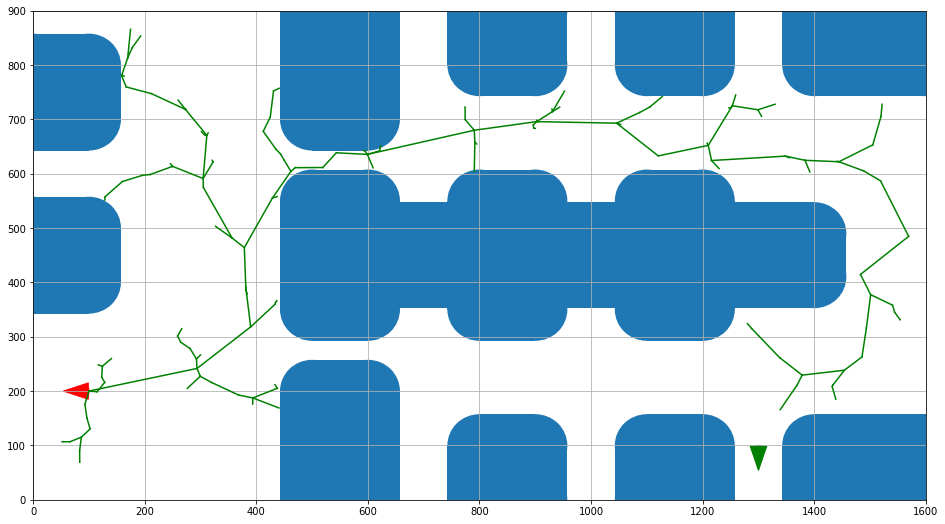

In [12]:
path = rrt_planner(xi,xf)

In [13]:
def pathVisualization(path):
    traj = []
    i = len(path) - 1
    while i >= 1:
        traj_temp,_ = traj_generate(path[i],path[i-1],mode=0)
        traj = traj + traj_temp
        i = i - 1
    
    initial_state = path[-1]
    final_state = path[0]
    ax = OperationSpace(initial_state,final_state,parkingLot)
    
    for state in traj:
        c = plt.Circle((state[0],state[1]),R/2,fill=0,color = 'r')
        arrow = plt.arrow(state[0],state[1],np.cos(state[2]),np.sin(state[2]),width=10,color = 'r')
        ax.add_patch(c)
        ax.add_patch(arrow)
    plt.show()
    

# 3 Evaluation

## 3.1 Parking Performance Evaluation
The first demo is head-in parking on slot (1200,1400). Note that RRT is not an optimal algorithm so that every trial will yield in different path.

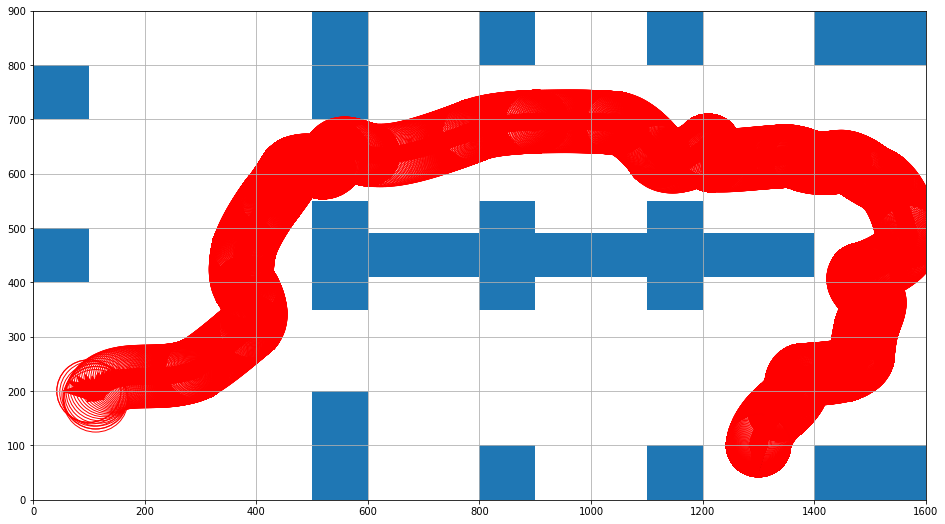

In [14]:
pathVisualization(path)

The second demo is rear-in parking on slot(1000,800)

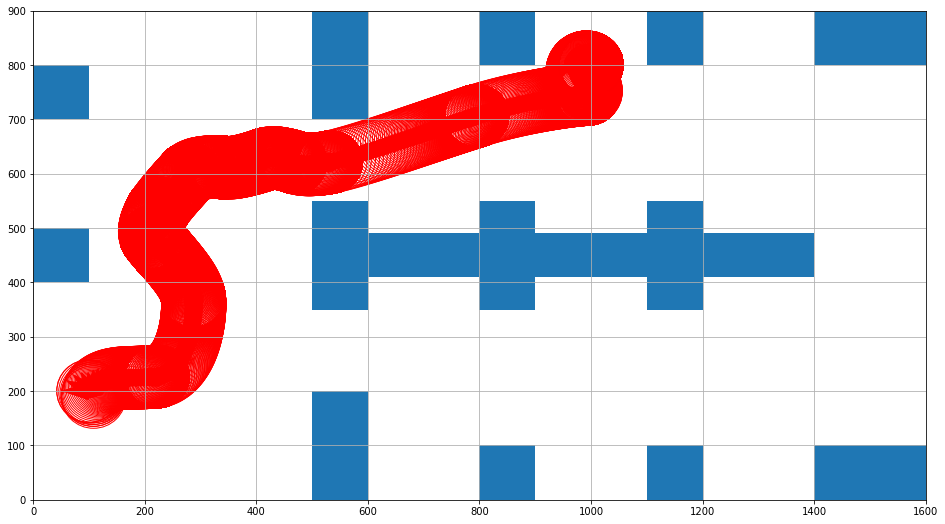

In [15]:
xf = [1000,800,-np.pi/2]
path = rrt_planner(xi,xf,animation=False)
pathVisualization(path)

The third demo is parallel parking on slot(500,700)

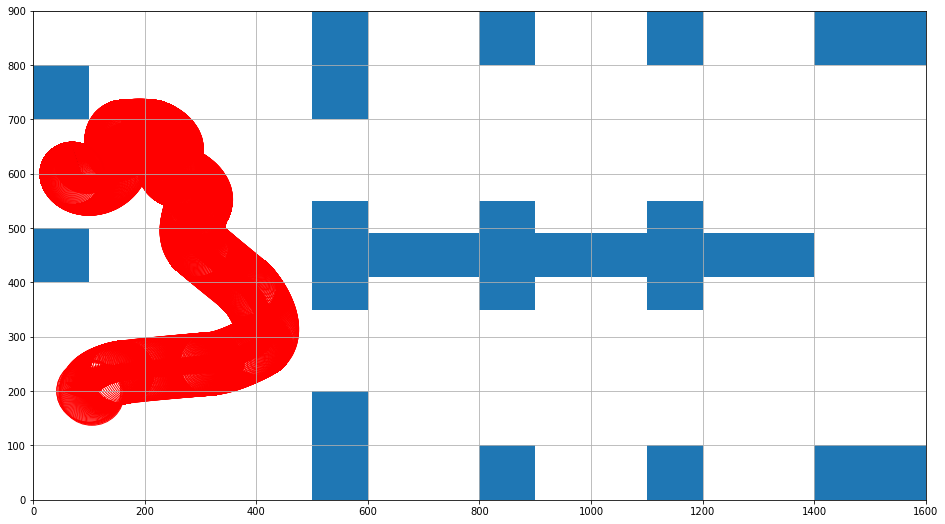

In [16]:
xf = [70,600,np.pi/2]
path = rrt_planner(xi,xf,animation=False)
pathVisualization(path)

As can be seen from some demo examples (parallel parking, head-in parking and rear-in parking), the RRT algorithm eventually leads the robot to the goal state.